In [1]:
!pip install stable-baselines3[extra] gymnasium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 2.9 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
import numpy as np
import matplotlib.pyplot as plt
import time


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
from typing import Optional, Tuple, Set

In [7]:
from gymnasium import spaces

In [8]:
def _circle_sprite(rgb, fill_alpha=1.0, edge_rgb=(0,0,0)):
    s = np.zeros((8,8,4), float); cx=3.5; cy=3.5
    for r in range(8):
        for c in range(8):
            d = ((r-cx)**2 + (c-cy)**2)**0.5
            if d <= 3.2: s[r,c,:3]=rgb; s[r,c,3]=fill_alpha
            if 2.9 < d <= 3.5: s[r,c,:3]=edge_rgb; s[r,c,3]=1.0
    return s

def _square_sprite(rgb, alpha=1.0):
    s = np.zeros((8,8,4), float); s[:,:,:3]=rgb; s[:,:,3]=alpha; return s

_S_AGENT_IDLE  = _circle_sprite((0.90, 0.10, 0.10))
_S_AGENT_CARRY = _circle_sprite((0.95, 0.55, 0.10))
_S_SHELF   = _square_sprite((0.15, 0.15, 0.15), 1.0)
_S_PICKUP  = _square_sprite((0.20, 0.70, 0.30), 0.95)
_S_DROPOFF = _square_sprite((0.20, 0.45, 0.90), 0.95)

def _background_texture(n: int):
    bg = np.zeros((n,n,4), float)
    for r in range(n):
        for c in range(n):
            shade = 0.84 if (r+c)%2==0 else 0.90
            dx = (r - (n-1)/2)/n; dy = (c - (n-1)/2)/n
            vign = 0.08*(dx*dx + dy*dy)
            bg[r,c,:3] = max(0.0, shade - vign); bg[r,c,3] = 1.0
    return bg

def render_grid_sprites(n: int, agent: Tuple[int,int], carrying: bool,
                        shelves: Set[Tuple[int,int]], pickup: Tuple[int,int],
                        dropoff: Tuple[int,int], title: str = ""):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(_background_texture(n), extent=[0,n,0,n], origin="lower", interpolation="nearest")

    def put(sprite, r, c):
        ax.imshow(sprite, extent=[c,c+1,r,r+1], origin="lower", interpolation="nearest", zorder=3)

    for (sr, sc) in shelves: put(_S_SHELF, sr, sc)
    pr, pc = pickup;  put(_S_PICKUP, pr, pc)
    dr, dc = dropoff; put(_S_DROPOFF, dr, dc)

    ar, ac = agent
    put(_S_AGENT_CARRY if carrying else _S_AGENT_IDLE, ar, ac)

    ax.set_xticks(np.arange(0, n+1, 1)); ax.set_yticks(np.arange(0, n+1, 1))
    ax.grid(which='both', color='black', linewidth=0.5, alpha=0.4)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.set_xlim(0,n); ax.set_ylim(0,n); ax.set_title(title)
    plt.show()

#  WarehouseDeterministicEnv class (from thhe Assignment 1)


class WarehouseDeterministicEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self,
                 grid_size: int = 6,
                 shelves: Optional[Set[Tuple[int,int]]] = None,
                 pickup: Tuple[int,int] = (0,0),
                 dropoff: Tuple[int,int] = (5,5),
                 max_steps: int = 300):
        super().__init__()
        self.n = grid_size
        self.shelves = set(shelves or {(2,2),(2,3),(3,2)})
        self.pickup = pickup
        self.dropoff = dropoff
        self.max_steps = max_steps

        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.Discrete(self.n*self.n*2)

        self.agent = (0,0)
        self.carrying = False
        self.steps = 0
        self._picked_once = False

    def _obs_id(self, pos: Tuple[int,int], carrying: bool) -> int:
        r, c = pos
        return (r*self.n + c) + (self.n*self.n if carrying else 0)

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.agent = (0,0)
        self.carrying = False
        self.steps = 0
        self._picked_once = False
        return self._obs_id(self.agent, self.carrying), {}

    def step(self, action: int):
        r, c = self.agent
        reward = -1.0
        terminated = False
        truncated = False

        if action in (0,1,2,3):
            dr, dc = {0:(-1,0), 1:(1,0), 2:(0,-1), 3:(0,1)}[action]
            nr, nc = r+dr, c+dc
            if 0 <= nr < self.n and 0 <= nc < self.n and (nr,nc) not in self.shelves:
                self.agent = (nr, nc)
            else:
                reward += -20.0
        elif action == 4:  # Pick
            if self.agent == self.pickup and not self.carrying:
                self.carrying = True
                if not self._picked_once:
                    reward += 25.0
                    self._picked_once = True
        elif action == 5:  # Drop
            if self.agent == self.dropoff and self.carrying:
                reward += 100.0
                terminated = True
            elif self.agent != self.dropoff:
                reward += -10.0
                print("Wrong drop off")

        self.steps += 1
        if self.steps >= self.max_steps:
            truncated = True

        obs = self._obs_id(self.agent, self.carrying)
        return obs, reward, terminated, truncated, {}

    def render(self):
        render_grid_sprites(
            n=self.n, agent=self.agent, carrying=self.carrying,
            shelves=self.shelves, pickup=self.pickup, dropoff=self.dropoff,
            title=f"Deterministic | agent={self.agent} | carrying={self.carrying}"
        )



env_dqn = WarehouseDeterministicEnv()
state_size = env_dqn.observation_space.n
action_size = env_dqn.action_space.n
print(f"State space: {state_size}, Action space: {action_size}")

State space: 72, Action space: 6


In [10]:
!pip install swig
!pip install "gymnasium[box2d]"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2399019 sha256=d7184c0261a4be633c78483258d60237b45caaf5dbefd359b6c3e3dc8a484197
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [11]:
env_grid = WarehouseDeterministicEnv()
env_cart = gym.make("CartPole-v1")
env_lunar = gym.make("LunarLander-v3")


/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [12]:
def train_sb3_dqn(env, model_name, total_timesteps=20000):
    start = time.time()
    model = DQN("MlpPolicy", env, verbose=0, learning_rate=1e-3, buffer_size=50000)
    model.learn(total_timesteps=total_timesteps)
    elapsed = time.time() - start
    model.save(model_name)
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=5)
    return model, mean_reward, std_reward, elapsed


In [13]:
results = {}

model_grid, r_grid, s_grid, t_grid = train_sb3_dqn(env_grid, "sb3_dqn_grid", 20000)
results["GridWorld/CartPole"] = (r_grid, s_grid, t_grid)

model_cart, r_cart, s_cart, t_cart = train_sb3_dqn(env_cart, "sb3_dqn_cart", 40000)
results["CartPole-v1"] = (r_cart, s_cart, t_cart)

model_lunar, r_lunar, s_lunar, t_lunar = train_sb3_dqn(env_lunar, "sb3_dqn_lunar", 60000)
results["LunarLander-v3"] = (r_lunar, s_lunar, t_lunar)


Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop off
Wrong drop

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [14]:
print(f"{'Environment':<20} {'Mean Reward':>15} {'Std':>10} {'Time (s)':>10}")
for env, (mean, std, t) in results.items():
    print(f"{env:<20} {mean:>15.2f} {std:>10.2f} {t:>10.1f}")


Environment              Mean Reward        Std   Time (s)
GridWorld/CartPole           -275.00       0.00       35.5
CartPole-v1                   134.60      50.30       44.4
LunarLander-v3               -129.76      14.09       74.4


In [15]:
obs, _ = env_cart.reset()
done = False
while not done:
    action, _ = model_cart.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env_cart.step(action)
    done = terminated or truncated
    env_cart.render()
env_cart.close()


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/classic_control/cartpole.py:250: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


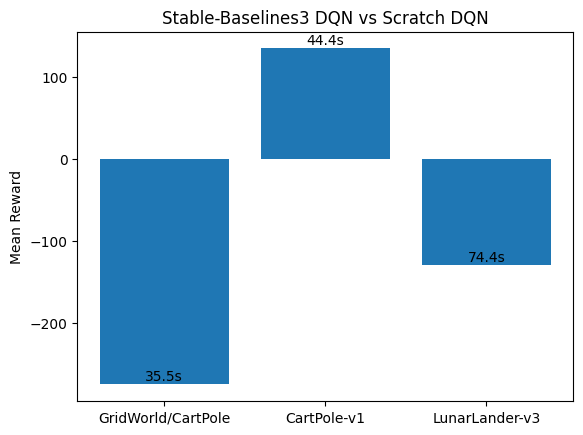

In [16]:
labels = list(results.keys())
rewards = [results[k][0] for k in labels]
times = [results[k][2] for k in labels]

fig, ax1 = plt.subplots()
ax1.bar(labels, rewards)
ax1.set_ylabel("Mean Reward")
ax1.set_title("Stable-Baselines3 DQN vs Scratch DQN")

for i, t in enumerate(times):
    ax1.text(i, rewards[i]+5, f"{t:.1f}s", ha='center')
plt.show()
